In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Cluster MNIST classes

1. Extract features using a auto-encoder
2. Reduce to 2 dimensions (TSNE or PCA)
3. Plot

1. Load and prepare data

In [2]:
transform = transforms.Compose([transforms.ToTensor()]) # https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html -> Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

batch_size = 64
#https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:01<00:00, 8339286.15it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14322025.75it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7077788.74it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4558633.35it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



2. Create the model

In [7]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28,128), nn.ReLU(), nn.Linear(128,64), nn.ReLU(), nn.Linear(64,32))
        self.decoder = nn.Sequential(nn.Linear(32,64), nn.ReLU(), nn.Linear(64,128), nn.ReLU(), nn.Linear(128,28*28))
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.parameters(), lr = 0.05)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train_autoencoder(self, train_loader, num_epochs, device):
        self.to(device)
        for epoch in range(num_epochs):
            for data in train_loader:
                inputs, _ = data
                inputs = inputs.view(inputs.size(0), -1).to(device) # What is this doing ?
                self.optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, inputs)
                loss.backward()
                self.optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    def encode_images(self, data_loader, device):
        encoded_images = []
        self.eval()
        with torch.no_grad():
            for data in data_loader:
                inputs, _ = data
                inputs = inputs.view(inputs.size(0), -1).to(device)
                encoded = self.encoder(inputs)
                encoded_images.append(encoded)

        return torch.cat(encoded_images).cpu().numpy()



Using cpu


3. Train the model

In [8]:
model = Autoencoder()

num_epochs = 10

model.train_autoencoder(train_loader=train_loader,num_epochs=num_epochs,device=device)

#def train_autoencoder(self, train_loader, num_epochs, device)


Epoch [1/10], Loss: 0.0967
Epoch [2/10], Loss: 0.0698
Epoch [3/10], Loss: 0.0631
Epoch [4/10], Loss: 0.0682
Epoch [5/10], Loss: 0.0653
Epoch [6/10], Loss: 0.0710
Epoch [7/10], Loss: 0.0631
Epoch [8/10], Loss: 0.0650
Epoch [9/10], Loss: 0.0610
Epoch [10/10], Loss: 0.0674


4. Plot data

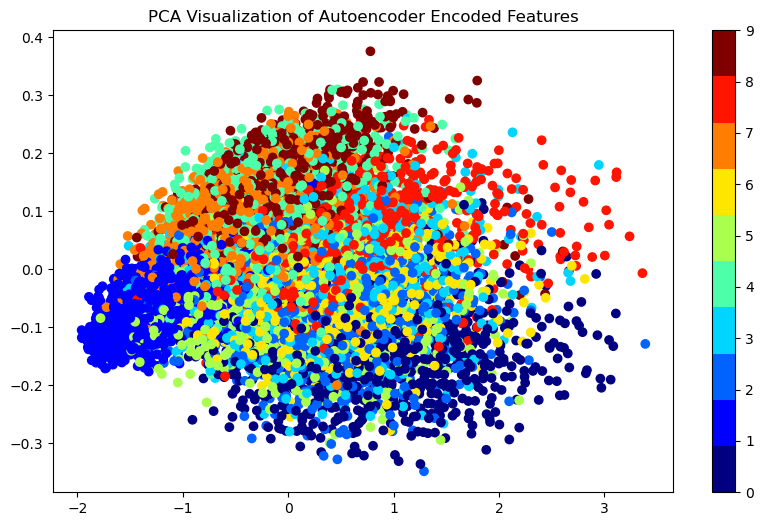

In [9]:
# Encode the test images
encoded_images = model.encode_images(test_loader, device)

from sklearn.decomposition import PCA

# Create a PCA instance
pca = PCA(n_components=2)

# Fit and transform the encoded_images
pca_results = pca.fit_transform(encoded_images)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=test_dataset.targets, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(0, 9)
plt.title("PCA Visualization of Autoencoder Encoded Features")
plt.show()


If we try to use a MLP to classify MNIST, how good/bad would it work ?

Think about it, and then build it.

1. Define model.
2. Train
3. Evaluate

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        
        self.fc = nn.Sequential(nn.Linear(input_size,hidden_size), nn.ReLU(),nn.Linear(hidden_size,num_classes))

    def forward(self, x):
        x= x.view(x.size(0),-1) #Flatten the input
        x= self.fc(x)

        #output = self.sigmoid(x)
        #.....

        return x

In [ ]:
# Initialize the model and set hyperparameters
input_size = 4  # Number of features in the Iris dataset
hidden_size = 128
num_classes = 10  # 0 a 9


model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss() #multi-class loss
optimizer = optim.Adam(model.parameters(), lr = learning_rate) #muito pequeno ficas preso em minimos locais, muito grandes ficas às voltas na função pq os passos sao muito grandes

# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
with torch.no_grad():
    y_pred = model(X_test)
    _, predicted = torch.max(y_pred, 1)

    # Generate the classification report
    report = classification_report(y_test, predicted)
    print(report)